# A quick Lithospheric Model with visco-plastic non-linear rheologies

version 0.2
Romain Beucher
romain.beucher@unimelb.edu.au

The following tutorial presents a simple usage of the geodynamics module.
The *geodynamics* module intents to facilitate rapid prototyping of geodynamics models. It can be seen as a set of high-level functions within the underworld ecosystem. It is a means to quickly get the user into Underworld modelling and assumes very little knowledge in coding. The module make some assumptions based on how the user defines the boundary conditions and the properties of the materials (rocks, phases). 

Its simplicity comes with a relatively more rigid workflow (compared to the classic Underworld functions).
However, the user can easily break the high level objects and get back to core Underworld function at any step of model design. As we think the low-level interface is more flexible, and in so allows for more complex models, we strongly encourage users to explore and break the High Level functions. We hope that the user will naturally move to the low-level functionalities as he or her gets more confident, and by doing so will access the wide range of possibilities offered by Underworld.

The module can be imported as follows:

In [1]:
import unsupported.geodynamics as GEO

/root/underworld2/unsupported/scaling/__init__.py:13: UserWarning: 

    The scaling module is not supported.

    It requires 'pint' as a dependency.

    You can install pint by running:

    'pip install pint' in a terminal

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/root/underworld2/unsupported/lithopress/__init__.py:8: UserWarning: 

The lithopress module is not supported.

Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/root/underworld2/unsupported/LecodeIsostasy/__init__.py:10: UserWarning: 

    The LecodeIsostasy module is not supported.

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [2]:
u = GEO.UnitRegistry

## Scaling

# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [3]:
Model = GEO.Model(elementRes=(180, 60), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  periodic=(False, False), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [4]:
Model.outputDir="test"

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [5]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)
Model.thermalExpansivity = 3e-5 / u.kelvin

The Model we are building is essentially a layered cake. The geodynamics module provide and easy way to define a layer by defining shape as *layer* and specifying its *top* and *bottom*. The order is important: when 2 shapes overlay each other, only the second is used.

In [7]:
# Air Layer
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.radiogenicHeatProd = 0.0
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
air.thermalExpansivity = 0.0

In [8]:
# Uppercrust Layer
uppercrust = Model.add_material(name="Upper Crust", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-20. * u.kilometer))
uppercrust.density  = 2620. * u.kilogram / u.metre**3
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3

In [9]:
# Midcrust Layer
midcrust = Model.add_material(name="Mid Crust", shape=GEO.shapes.Layer(top=-20. * u.kilometer, bottom=-25. * u.kilometer))
midcrust.density = 2900. * u.kilogram / u.metre**3
midcrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

In [10]:
# Heavy Crust Layer
heavycrust = Model.add_material(name="Heavy Crust", shape=GEO.shapes.Layer(top=-35. * u.kilometer, bottom=-40. * u.kilometer))
heavycrust.density  = 2900. * u.kilogram / u.metre**3
heavycrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3

In [11]:
# Lower Crust Layer
lowercrust = Model.add_material(name="Lower Crust",shape=GEO.shapes.Layer(top=-25. * u.kilometer, bottom=-60. * u.kilometer))
lowercrust.density  = 2800. * u.kilogram / u.metre**3
lowercrust.radiogenicHeatProd = 0.4 * u.microwatt / u.meter**3

In [12]:
# Mantle Layer

mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=-60. * u.kilometer, bottom=Model.bottom))
mantle.density = 3370. * u.kilogram / u.metre**3
mantle.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

Now we want to define the fault. We can do that by specifying a list of vertices defining the polygon shape.

In [13]:
# Fault
vertices = [(169.  * u.kilometer,  0. * u.kilometer),
            (171. * u.kilometer,  0. * u.kilometer),
            (191. * u.kilometer, -20. * u.kilometer),
            (189. * u.kilometer, -20. * u.kilometer)]

fault = Model.add_material(name="Fault", shape=GEO.shapes.Polygon(vertices))
fault.density = 2620. * u.kilogram / u.metre**3
fault.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3

We can visualize the material field by calling the *plot_material()* method.


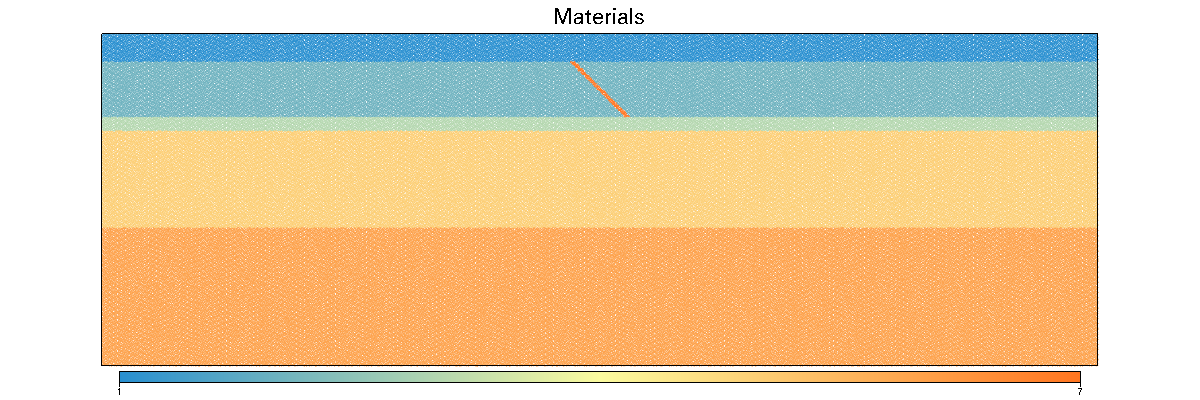

In [14]:
Fig = Model.plot_material()

In the example above, I have intentionally defined the *heavy crust* layer before the *lower crust*. Those two layers are defined in the same interval and only the *lower crust* appears in the above plot.
It is possible to change the drawing order of the materials once all the materials have been defined:

In [15]:
Model.material_drawing_order = [fault, mantle, heavycrust, lowercrust, midcrust, uppercrust, air]


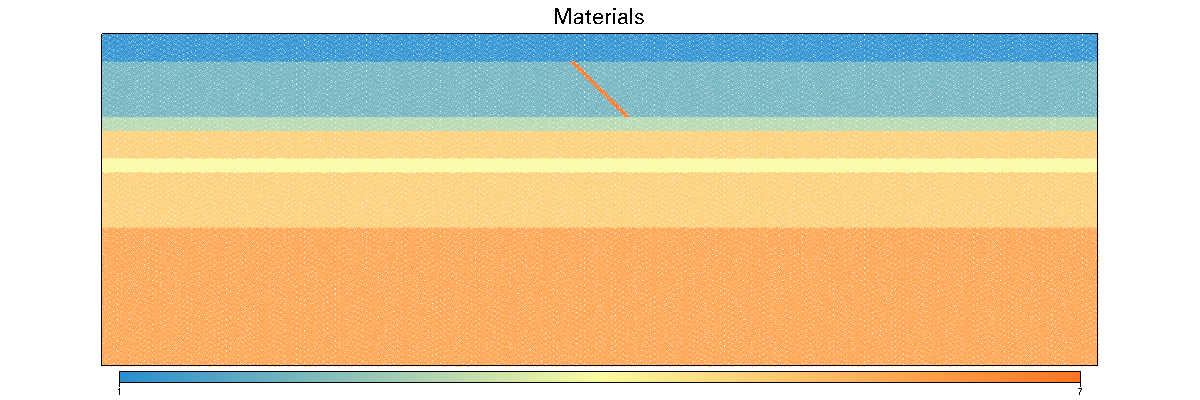

In [16]:
Fig = Model.plot_material()

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [17]:
air.viscosity        = GEO.ConstantViscosity(1e19 * u.pascal * u.second)
uppercrust.viscosity = GEO.ViscousCreep(predefined="Patterson et al., 1990")
midcrust.viscosity   = GEO.ViscousCreep(predefined="Goetze et al., 1978")
lowercrust.viscosity = GEO.ViscousCreep(predefined="Wang et al., 2012")
heavycrust.viscosity = GEO.ViscousCreep(predefined="Goetze et al., 1978")
mantle.viscosity     = GEO.ViscousCreep(predefined="Hirth et al., 2003")
fault.viscosity      = GEO.ConstantViscosity(1e19 * u.pascal * u.second)

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [18]:
uppercrust.plasticity = GEO.DruckerPrager(predefined="Rey et al., 2010 (UpperCrust)")
midcrust.plasticity   = GEO.DruckerPrager(predefined="Rey et al., 2010 (UpperCrust)")
lowercrust.plasticity = GEO.DruckerPrager(predefined="Rey et al., 2010 (LowerCrust)")
heavycrust.plasticity = GEO.DruckerPrager(predefined="Rey et al., 2010 (LowerCrust)")
fault.plasticity      = GEO.DruckerPrager(predefined="Rey et al., 2010 (Mantle)")

## Temperature Boundary Condition


In [19]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         indexSets=[(mantle.indices, 1603.15 * u.degK), (air.indices, 293.15 * u.degK )])

## Velocity Boundary Conditions

In [20]:
from unsupported.LecodeIsostasy import LecodeIsostasy

In [23]:
Model.set_velocityBCs(left=[-1.8 * u.centimeter / u.year, None],
                       right=[1.8 * u.centimeter / u.year, None],
                       bottom=LecodeIsostasy(reference_mat=mantle.index))

## Run Model

In [24]:
Model.init_model()


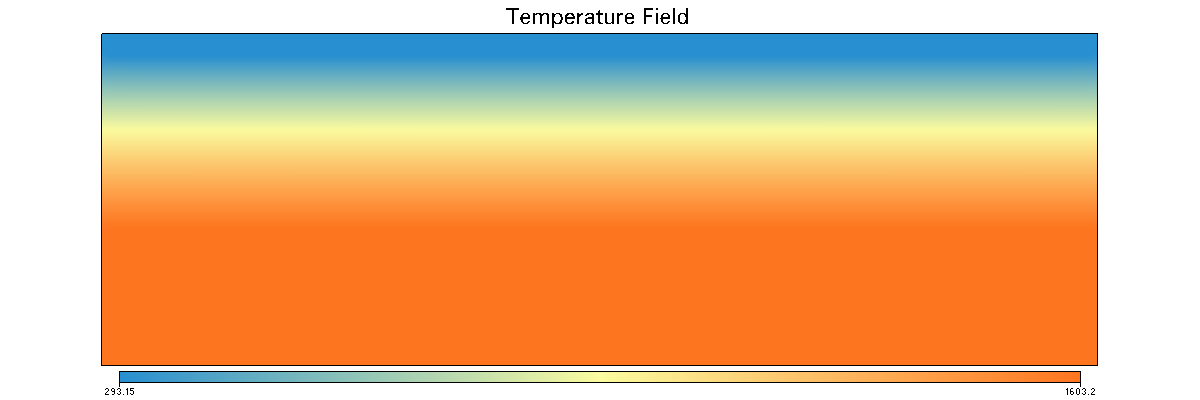

In [25]:
Fig = Model.plot_temperature()


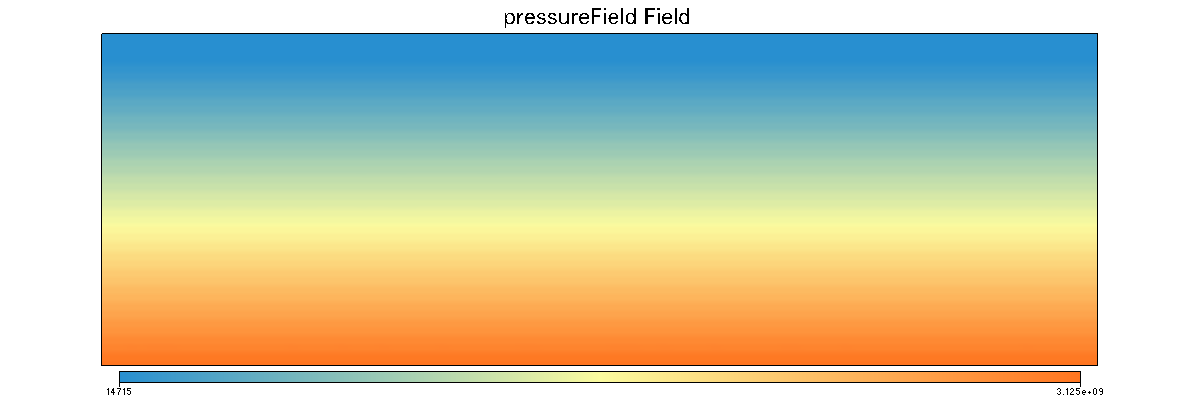

In [26]:
Fig = Model.plot_pressureField()

In [30]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)

In [31]:
Model.run_for(30000.* u.years, checkpoint=5000.*u.years)

Time:  5000.0 year
Time:  10000.0 year
Time:  15000.0 year
Time:  20000.0 year
Time:  25000.0 year
Time:  30000.0 year


In [32]:
Model.time

<Quantity(0.03, 'megayear')>


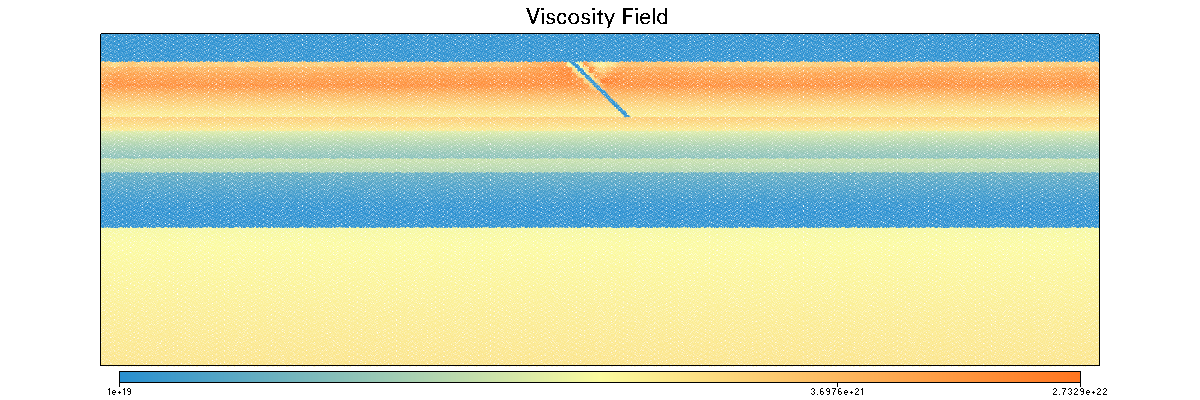

In [33]:
Fig = Model.plot_viscosity()

Parameter 'resolutionI' is deprecated, please use resolution=[I,J,K]
Parameter 'resolutionJ' is deprecated, please use resolution=[I,J,K]



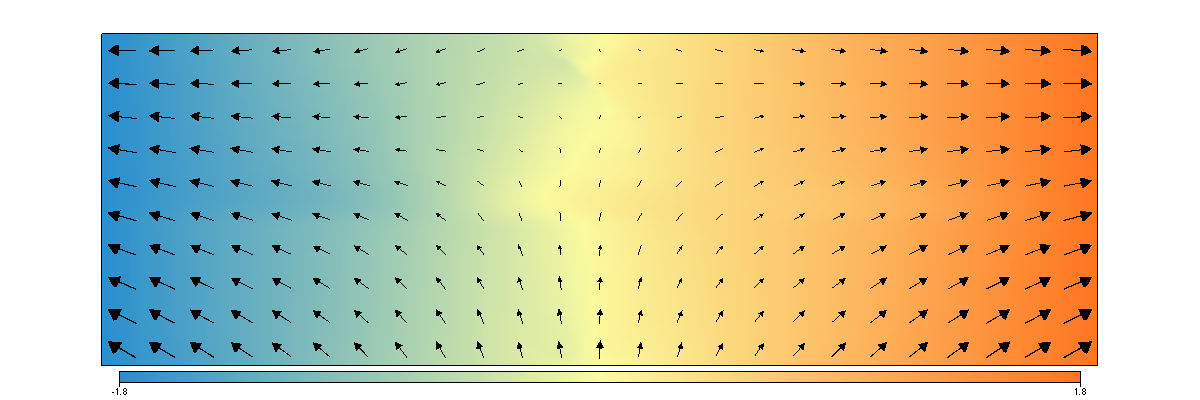

In [36]:
Fig = Model.plot_velocityField()


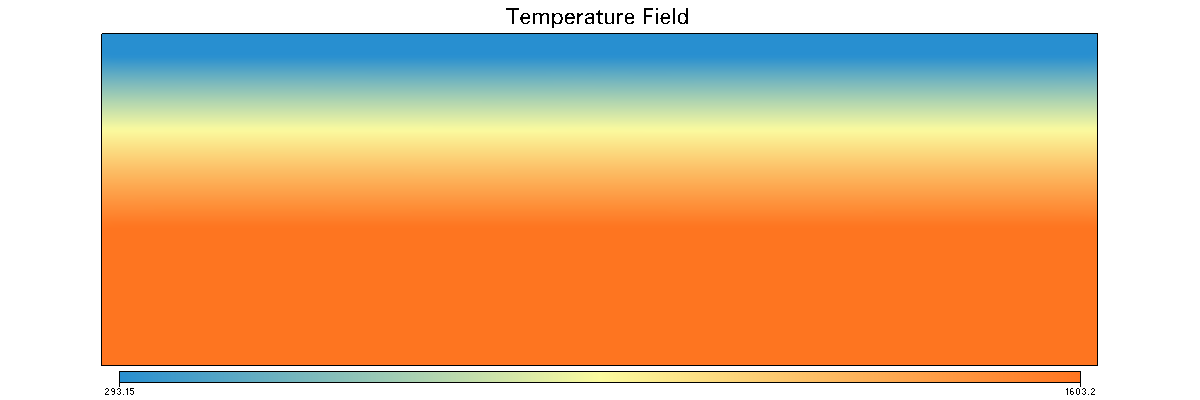

In [34]:
Fig = Model.plot_temperature()


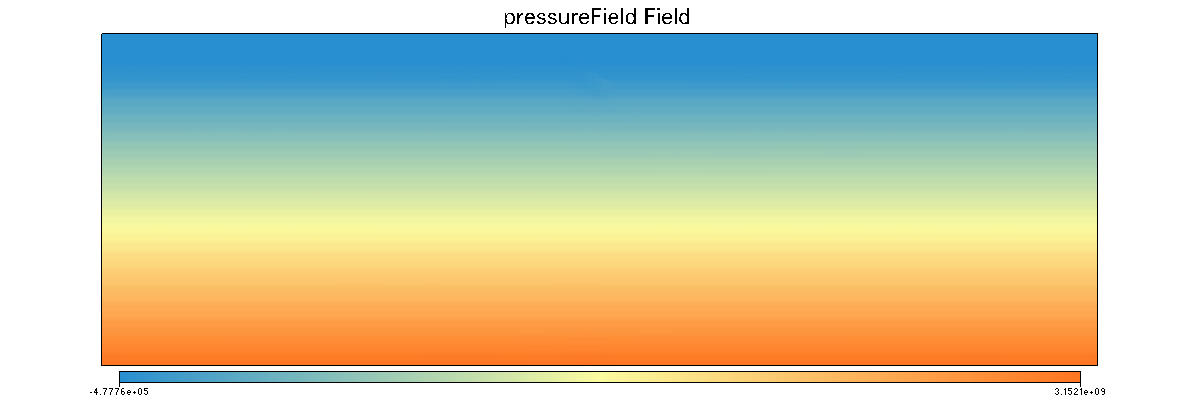

In [37]:
Fig = Model.plot_pressureField()

In [38]:
Model.run_for(1.0 * u.megayear, checkpoint=100000*u.year)

Time:  0.0780305518963 megayear
Time:  0.126822158039 megayear
Time:  0.13 megayear
Time:  0.172934074868 megayear
Time:  0.21053828984 megayear
Time:  0.23 megayear
Time:  0.27227788846 megayear
Time:  0.30514542421 megayear
Time:  0.33 megayear
Time:  0.356951741714 megayear
Time:  0.377007750452 megayear
Time:  0.404333849379 megayear
Time:  0.421727757865 megayear
Time:  0.43 megayear
Time:  0.479075786834 megayear
Time:  0.527718740407 megayear
Time:  0.53 megayear
Time:  0.575071739972 megayear
Time:  0.616555339526 megayear
Time:  0.63 megayear
Time:  0.673912361391 megayear
Time:  0.708003551076 megayear
Time:  0.73 megayear
Time:  0.766901995428 megayear
Time:  0.792371456252 megayear
Time:  0.810780487547 megayear
Time:  0.83 megayear
Time:  0.847247694597 megayear
Time:  0.86634638906 megayear
Time:  0.88438849987 megayear
Time:  0.902735668458 megayear
Time:  0.920762874725 megayear
Time:  0.93 megayear
Time:  0.959191996281 megayear
Time:  0.97430143898 megayear
Time:  0.9

In [1]:
Fig = Model.plot_material()

NameError: name 'Model' is not defined